In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import matplotlib.pyplot as plt
import numpy as np
import pickle

os.chdir('/Users/lucreziavaleriani/Documents/GitHub/LOCATE/')

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('./data/data.pkl', 'rb') as data:
    data_input = pickle.load(data)

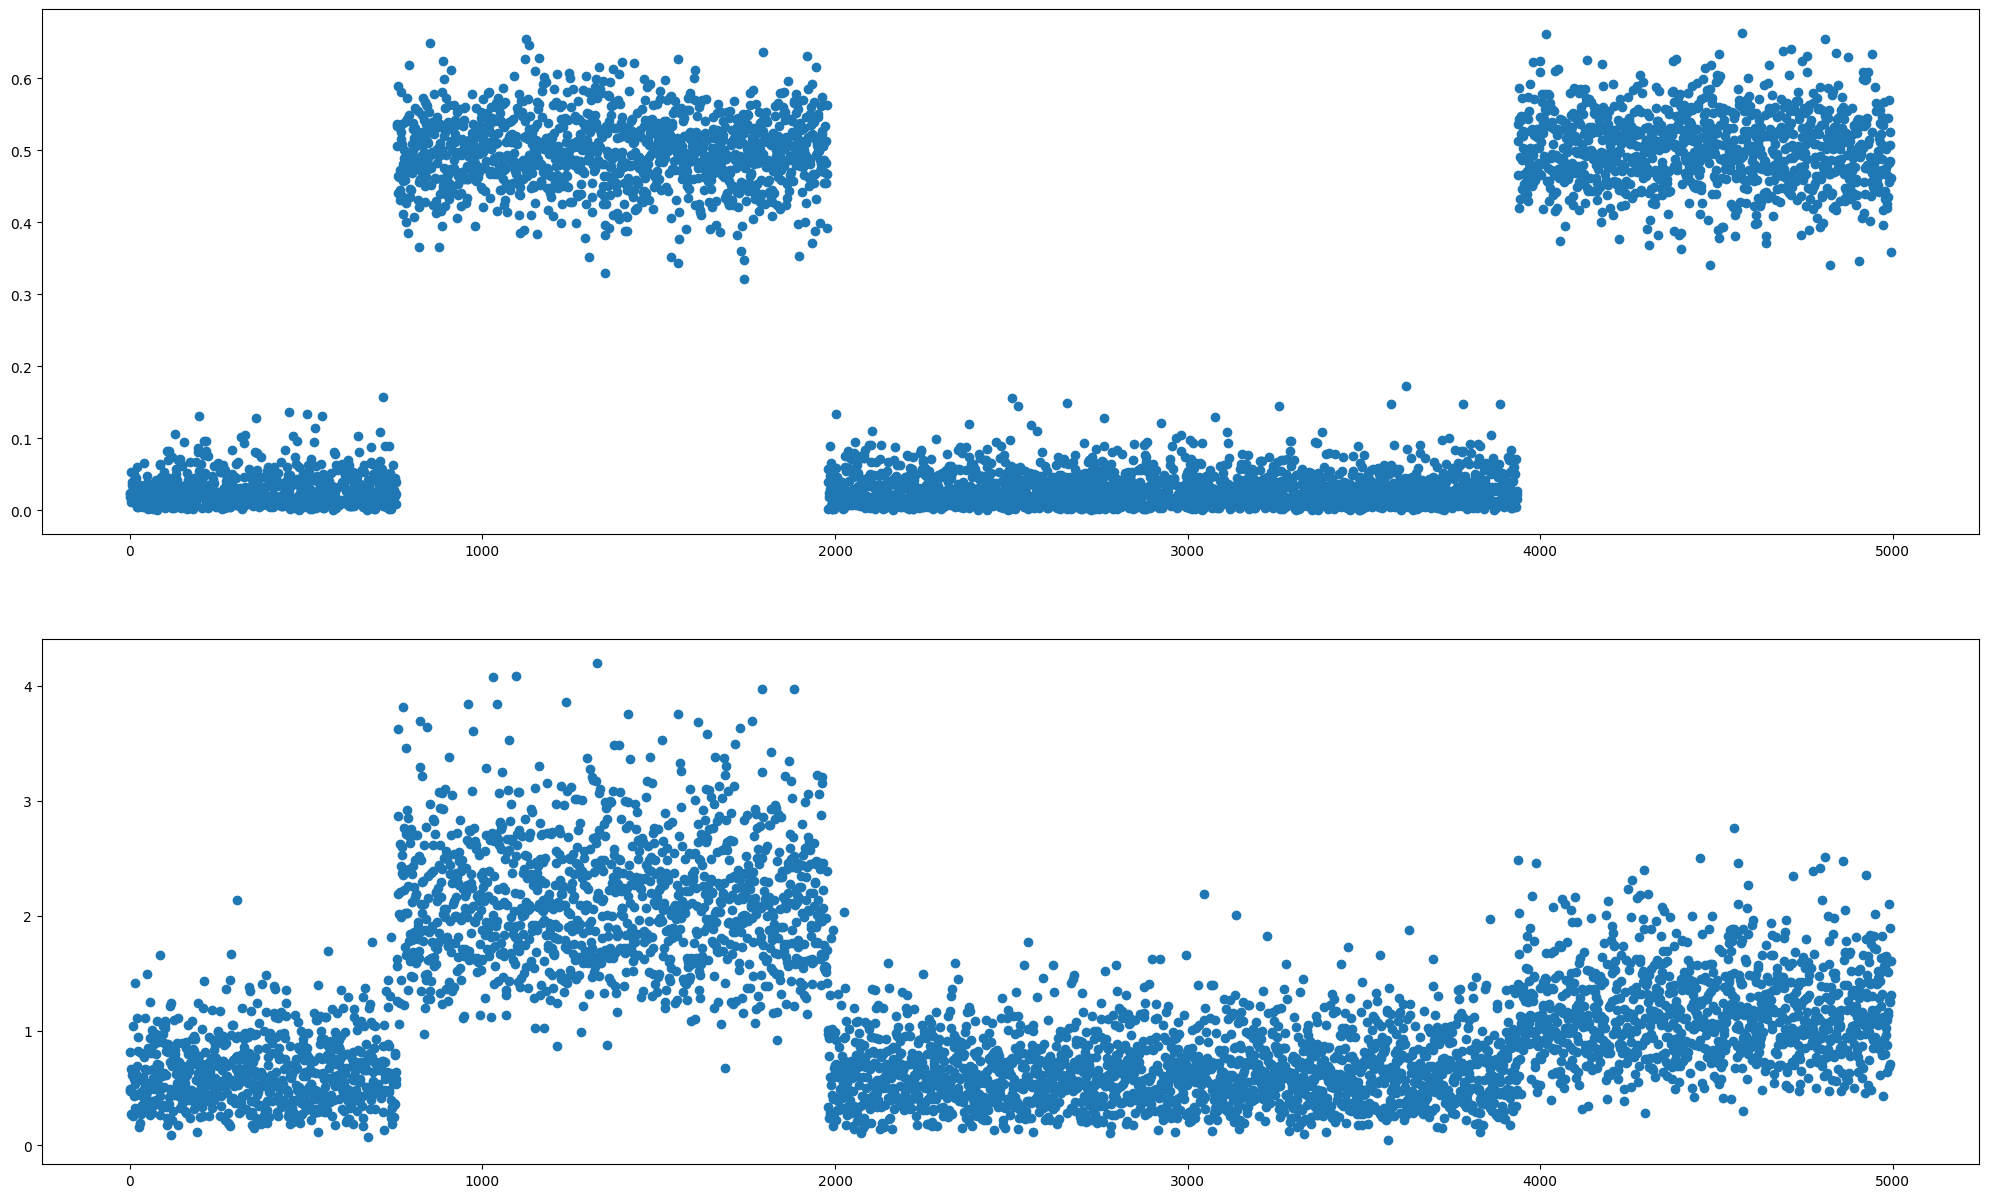

In [4]:
fig, axs = plt.subplots(2, figsize=(25, 15))
axs[0].plot(range(len(data_input['baf'])), data_input['baf'], 'o')
axs[1].plot(range(len(data_input['dr'])), data_input['dr'], 'o')

In [5]:
import locate as l
from locate.models import Clonal

In [6]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"], "dr": data_input["dr"], "vaf": None})
locate.set_model_params({"jumping_prob" : 1e-6})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [8]:
ll = locate.run(steps = 30, param_optimizer = {"lr":0.1})

[autoreload of locate.models.Clonal failed: Traceback (most recent call last):
  File "/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 335, in update_class
    if (old_obj == new_obj) is True:
        ^^^^^^^^^^^^^^^^^^
RuntimeError: Boolean value of Tensor with more than one value is ambiguous
]


NameError: name 'vaf_n_trial' is not defined

In [ ]:
bau = locate.learned_parameters()